#  <center> </center>
# <center>Trabajo Practico 1 </center>
### <center>Grupo 10 </center>
## Integrantes:
#### Alan Richmond
#### Flavian Ferré
#### Alan Mejia

# 0. Inicializacion de los datos

## Importando Librerias


In [403]:
#Manipulacion de datos
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from pandas.plotting import scatter_matrix
from shapely.wkt import loads
from shapely.geometry import Point
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.neighbors import NearestNeighbors
from sklearn.ensemble import IsolationForest
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans

# 3. Clasificacion

## Importado del dataset

In [404]:
conjunto_entrenamiento_final = pd.read_csv("Datasets/conjunto_entrenamiento_final.csv")
conjunto_entrenamiento_final

,latitud,longitud,place_l3,property_type,property_bedrooms,property_rooms,property_surface_covered,property_surface_total,property_price,price_per_square_meter
0,-34.637319,-58.361124,Boca,Departamento,2.0,3.0,55.0,58.0,82900.0,1429.310345
1,-34.628647,-58.361871,Boca,Departamento,3.0,4.0,70.0,70.0,99000.0,1414.285714
2,-34.610027,-58.401934,Balvanera,Departamento,2.0,4.0,104.0,138.0,146000.0,1057.971014
3,-34.631621,-58.416825,Boedo,PH,2.0,4.0,73.0,118.0,250000.0,2118.644068
4,-34.623886,-58.412746,Boedo,PH,1.0,2.0,46.0,61.0,100000.0,1639.344262
...,...,...,...,...,...,...,...,...,...,...
65445,-34.582800,-58.442800,Palermo,Departamento,1.0,1.0,32.0,36.0,98514.0,2736.500000
65446,-34.590332,-58.420135,Palermo,Departamento,3.0,4.0,72.0,81.0,200000.0,2469.135802
65447,-34.576232,-58.441949,Palermo,Departamento,2.0,3.0,57.0,62.0,130000.0,2096.774194
65448,-34.582800,-58.442800,Palermo,Departamento,1.0,1.0,32.0,36.0,100273.0,2785.361111


## a. Construccion del target

Vamos a mostrar la distribucion del precio por metro cuadrado.

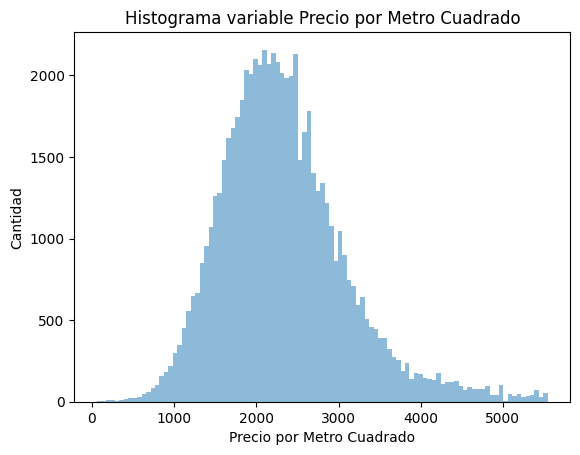

In [405]:
hist_pxm2=conjunto_entrenamiento_final['price_per_square_meter'].plot.hist(alpha=0.5,bins=101,
                                                                           title="Histograma variable Precio por Metro Cuadrado",
                                                                           xlabel="Precio por Metro Cuadrado",
                                                                           ylabel="Cantidad")

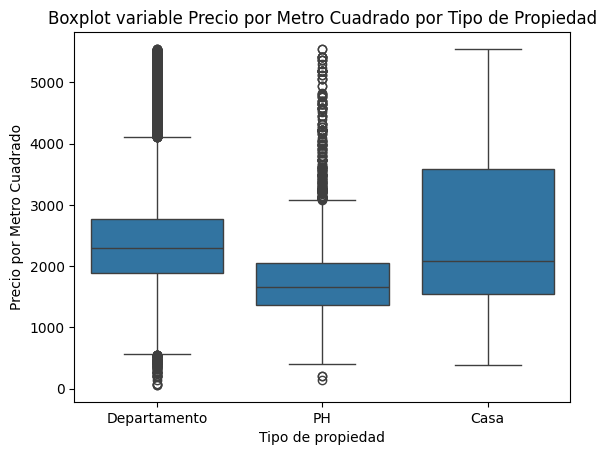

In [406]:
box_plot_pxm2_por_tipo=sns.boxplot(x="property_type",
                                   y="price_per_square_meter",
                                   data=conjunto_entrenamiento_final).set(title="Boxplot variable Precio por Metro Cuadrado por Tipo de Propiedad",
                                   xlabel="Tipo de propiedad",
                                   ylabel="Precio por Metro Cuadrado")

In [407]:
conjunto_entrenamiento_final['price_per_square_meter'].describe()

count    65450.000000
mean      2332.326853
std        768.293705
min         60.240964
25%       1811.602629
50%       2244.715360
75%       2732.048132
max       5546.875000
Name: price_per_square_meter, dtype: float64

In [408]:
conjunto_entrenamiento_final.groupby('property_type')['price_per_square_meter'].describe()

,count,mean,std,min,25%,50%,75%,max
property_type,,,,,,,,
Casa,1170.0,2578.364711,1340.922365,391.304348,1543.209877,2085.410334,3590.361446,5542.168675
Departamento,58240.0,2386.269074,739.932360,60.240964,1888.888889,2302.325581,2777.777778,5546.875000
PH,6040.0,1764.535591,637.932946,133.867470,1360.220588,1666.666667,2047.619048,5542.168675


Vamos a probar las tres altenativas siguientes :

### 1. Dividir la variable pxm2 en 3 intervalos con igual cantidad de observaciones.

Tenemos 67877 observaciones, asi vamos a divider el conjunto en 3 conjuntos de 22626 observaciones.

In [409]:
def assign_tipo_precio(df):
    df['tipo_precio'] = None
    limite_grupo_1 = int(np.round(df.shape[0] / 4))
    limite_grupo_2 = int(np.round(3 * df.shape[0] / 4))
    df.loc[:limite_grupo_1, 'tipo_precio'] = 'Bajo'
    df.loc[limite_grupo_1:limite_grupo_2, 'tipo_precio'] = 'Medio'
    df.loc[limite_grupo_2:, 'tipo_precio'] = 'Alto'
    return df

In [410]:
pxm2_ascending = conjunto_entrenamiento_final.sort_values(by=['price_per_square_meter'], ascending=True).reset_index(drop=True)
pxm2_ascending = assign_tipo_precio(pxm2_ascending)
pxm2_ascending

,latitud,longitud,place_l3,property_type,property_bedrooms,property_rooms,property_surface_covered,property_surface_total,property_price,price_per_square_meter,tipo_precio
0,-34.587265,-58.389767,Recoleta,Departamento,2.0,3.0,67.0,83.0,5000.0,60.240964,Bajo
1,-34.579756,-58.406144,Palermo,Departamento,2.0,3.0,110.0,120.0,7500.0,62.500000,Bajo
2,-34.576973,-58.406591,Palermo Chico,Departamento,2.0,3.0,67.0,83.0,6200.0,74.698795,Bajo
3,-34.569770,-58.431032,Palermo,Departamento,3.0,4.0,136.0,145.0,11111.0,76.627586,Bajo
4,-34.612215,-58.360230,Puerto Madero,Departamento,2.0,3.0,67.0,83.0,11000.0,132.530120,Bajo
...,...,...,...,...,...,...,...,...,...,...,...
65445,-34.614185,-58.462744,Villa Gral. Mitre,Casa,2.0,3.0,67.0,83.0,460000.0,5542.168675,Alto
65446,-34.552525,-58.487006,Saavedra,Casa,2.0,3.0,67.0,83.0,460000.0,5542.168675,Alto
65447,-34.617091,-58.373067,San Telmo,PH,2.0,3.0,67.0,83.0,460000.0,5542.168675,Alto
65448,-34.605177,-58.444223,Villa Crespo,Casa,2.0,3.0,67.0,83.0,460000.0,5542.168675,Alto


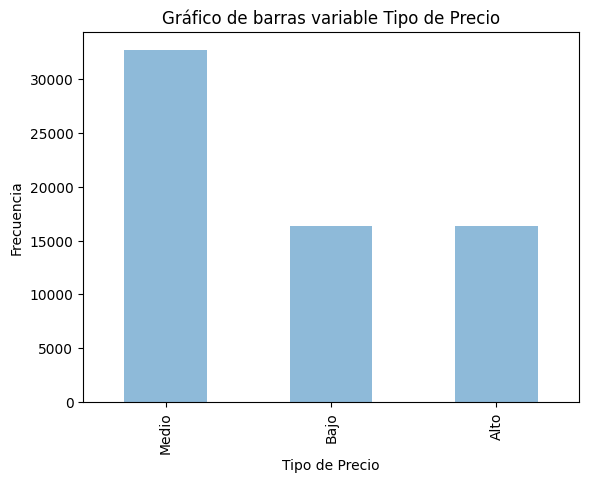

In [411]:
barras_pxm2_ascending=pxm2_ascending['tipo_precio'].value_counts().plot.bar(alpha=0.5,
                                                      title="Gráfico de barras variable Tipo de Precio",
                                                      xlabel="Tipo de Precio" ,
                                                      ylabel="Frecuencia")

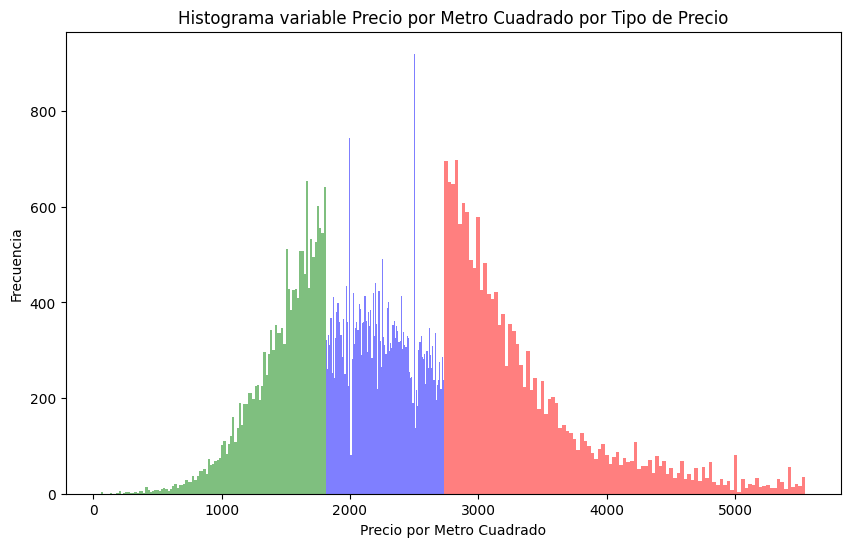

In [412]:
colors = {'Alto': 'red', 'Medio': 'blue', 'Bajo': 'green'}
plt.figure(figsize=(10, 6))
for tipo_precio, color in colors.items():
    data_por_tipo = pxm2_ascending[pxm2_ascending['tipo_precio'] == tipo_precio]['price_per_square_meter']
    plt.hist(data_por_tipo, bins=101, color=color, alpha=0.5, label=tipo_precio)

plt.title("Histograma variable Precio por Metro Cuadrado por Tipo de Precio")
plt.xlabel("Precio por Metro Cuadrado")
plt.ylabel("Frecuencia")
plt.show()

### 2. Dividir la variable pxm2 en 3 intervalos, el primero con el 25% de las observaciones, el siguiente con el 50% y el último con el 25% de las observaciones restantes.

In [413]:
pxm2_ascending_2 = pxm2_ascending.copy()
pxm2_ascending_2 = assign_tipo_precio(pxm2_ascending_2)
pxm2_ascending_2

,latitud,longitud,place_l3,property_type,property_bedrooms,property_rooms,property_surface_covered,property_surface_total,property_price,price_per_square_meter,tipo_precio
0,-34.587265,-58.389767,Recoleta,Departamento,2.0,3.0,67.0,83.0,5000.0,60.240964,Bajo
1,-34.579756,-58.406144,Palermo,Departamento,2.0,3.0,110.0,120.0,7500.0,62.500000,Bajo
2,-34.576973,-58.406591,Palermo Chico,Departamento,2.0,3.0,67.0,83.0,6200.0,74.698795,Bajo
3,-34.569770,-58.431032,Palermo,Departamento,3.0,4.0,136.0,145.0,11111.0,76.627586,Bajo
4,-34.612215,-58.360230,Puerto Madero,Departamento,2.0,3.0,67.0,83.0,11000.0,132.530120,Bajo
...,...,...,...,...,...,...,...,...,...,...,...
65445,-34.614185,-58.462744,Villa Gral. Mitre,Casa,2.0,3.0,67.0,83.0,460000.0,5542.168675,Alto
65446,-34.552525,-58.487006,Saavedra,Casa,2.0,3.0,67.0,83.0,460000.0,5542.168675,Alto
65447,-34.617091,-58.373067,San Telmo,PH,2.0,3.0,67.0,83.0,460000.0,5542.168675,Alto
65448,-34.605177,-58.444223,Villa Crespo,Casa,2.0,3.0,67.0,83.0,460000.0,5542.168675,Alto


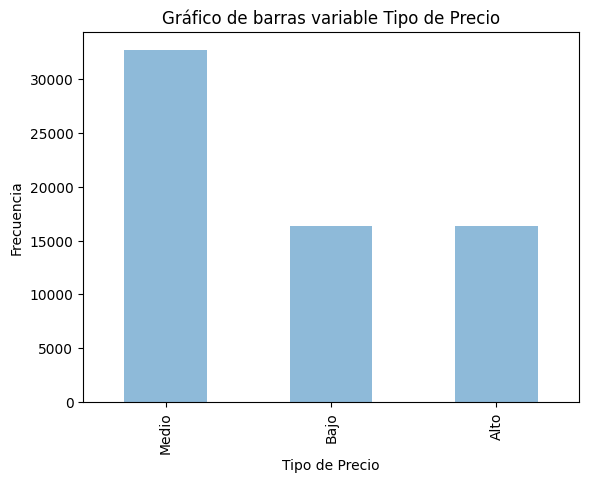

In [414]:
barras_pxm2_ascending_2=pxm2_ascending_2['tipo_precio'].value_counts().plot.bar(alpha=0.5,
                                                      title="Gráfico de barras variable Tipo de Precio",
                                                      xlabel="Tipo de Precio" ,
                                                      ylabel="Frecuencia")

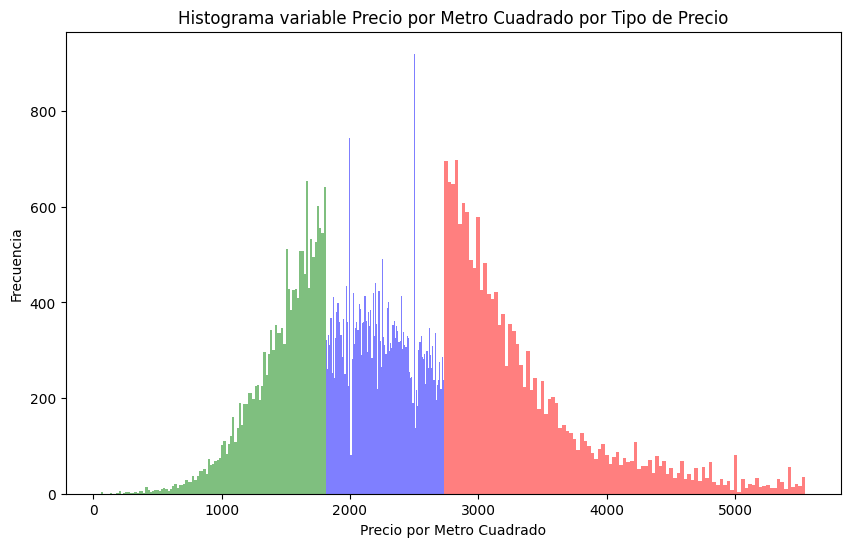

In [415]:
colors = {'Alto': 'red', 'Medio': 'blue', 'Bajo': 'green'}
plt.figure(figsize=(10, 6))
for tipo_precio, color in colors.items():
    data_por_tipo = pxm2_ascending_2[pxm2_ascending_2['tipo_precio'] == tipo_precio]['price_per_square_meter']
    plt.hist(data_por_tipo, bins=101, color=color, alpha=0.5, label=tipo_precio)

plt.title("Histograma variable Precio por Metro Cuadrado por Tipo de Precio")
plt.xlabel("Precio por Metro Cuadrado")
plt.ylabel("Frecuencia")
plt.show()

### 3. Trabajar la variable pxm2 relativa a cada tipo de propiedad y luego dividirla como en el punto anterior.

In [416]:
pxm2_ascending_3 = pxm2_ascending.copy()
pxm2_ascending_3_con_tipo_precio = pxm2_ascending_3.groupby('property_type').apply(assign_tipo_precio).reset_index(drop=True)
pxm2_ascending_3_con_tipo_precio

,latitud,longitud,place_l3,property_type,property_bedrooms,property_rooms,property_surface_covered,property_surface_total,property_price,price_per_square_meter,tipo_precio
0,-34.574142,-58.408867,Palermo,Casa,2.0,3.0,72.0,230.0,90000.0,391.304348,Bajo
1,-34.608300,-58.371200,Monserrat,Casa,2.0,3.0,67.0,83.0,40000.0,481.927711,Bajo
2,-34.657288,-58.411771,Nueva Pompeya,Casa,2.0,3.0,80.0,132.0,74000.0,560.606061,Bajo
3,-34.646343,-58.363495,Boca,Casa,2.0,3.0,117.0,146.0,85000.0,582.191781,Bajo
4,-34.653845,-58.464647,Parque Avellaneda,Casa,2.0,3.0,91.0,91.0,56800.0,624.175824,Bajo
...,...,...,...,...,...,...,...,...,...,...,...
65445,-34.597236,-58.395112,Recoleta,PH,2.0,3.0,67.0,83.0,450000.0,5421.686747,Alto
65446,-34.596541,-58.394830,Recoleta,PH,2.0,3.0,67.0,83.0,450000.0,5421.686747,Alto
65447,-34.616630,-58.430737,Caballito,PH,2.0,3.0,67.0,83.0,450000.0,5421.686747,Alto
65448,-34.609422,-58.450249,Caballito,PH,2.0,3.0,67.0,83.0,460000.0,5542.168675,Alto


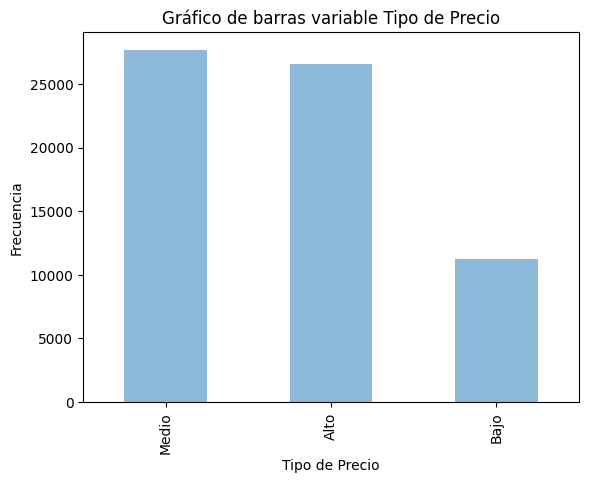

In [417]:
barras_pxm2_ascending_3=pxm2_ascending_3_con_tipo_precio['tipo_precio'].value_counts().plot.bar(alpha=0.5,
                                                      title="Gráfico de barras variable Tipo de Precio",
                                                      xlabel="Tipo de Precio" ,
                                                      ylabel="Frecuencia")

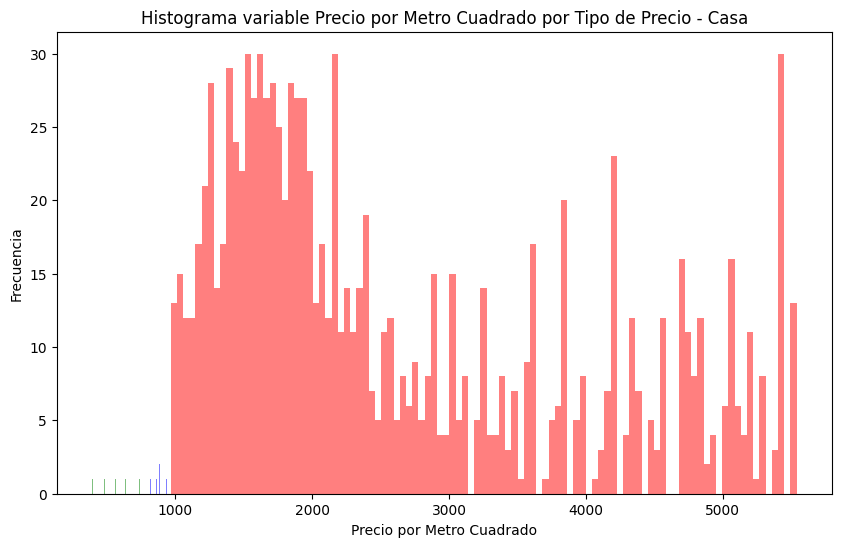

In [418]:
colors = {'Alto': 'red', 'Medio': 'blue', 'Bajo': 'green'}
plt.figure(figsize=(10, 6))
for tipo_precio, color in colors.items():
    data_por_tipo = pxm2_ascending_3_con_tipo_precio[(pxm2_ascending_3_con_tipo_precio['tipo_precio'] == tipo_precio) & (pxm2_ascending_3_con_tipo_precio['property_type'] == 'Casa')]['price_per_square_meter']
    plt.hist(data_por_tipo, bins=101, color=color, alpha=0.5, label=tipo_precio)

plt.title("Histograma variable Precio por Metro Cuadrado por Tipo de Precio - Casa")
plt.xlabel("Precio por Metro Cuadrado")
plt.ylabel("Frecuencia")
plt.show()

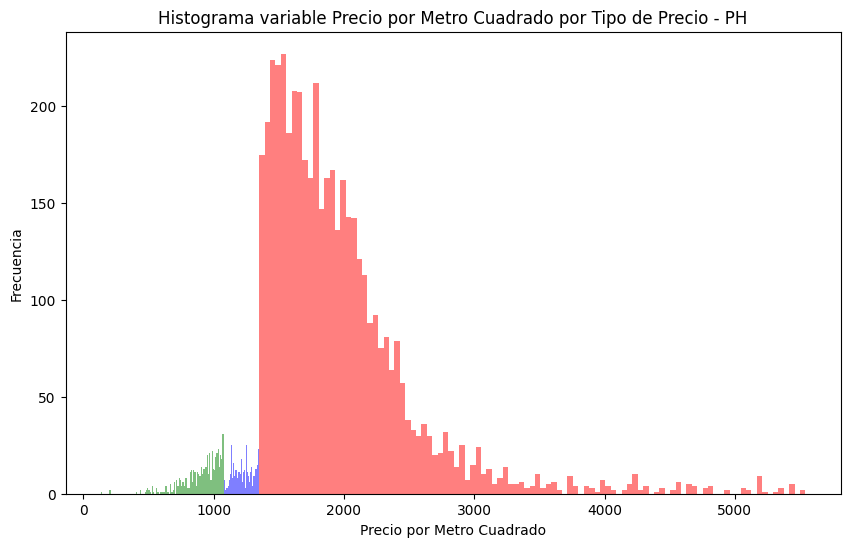

In [419]:
colors = {'Alto': 'red', 'Medio': 'blue', 'Bajo': 'green'}
plt.figure(figsize=(10, 6))
for tipo_precio, color in colors.items():
    data_por_tipo = pxm2_ascending_3_con_tipo_precio[(pxm2_ascending_3_con_tipo_precio['tipo_precio'] == tipo_precio) & (pxm2_ascending_3_con_tipo_precio['property_type'] == 'PH')]['price_per_square_meter']
    plt.hist(data_por_tipo, bins=101, color=color, alpha=0.5, label=tipo_precio)

plt.title("Histograma variable Precio por Metro Cuadrado por Tipo de Precio - PH")
plt.xlabel("Precio por Metro Cuadrado")
plt.ylabel("Frecuencia")
plt.show()

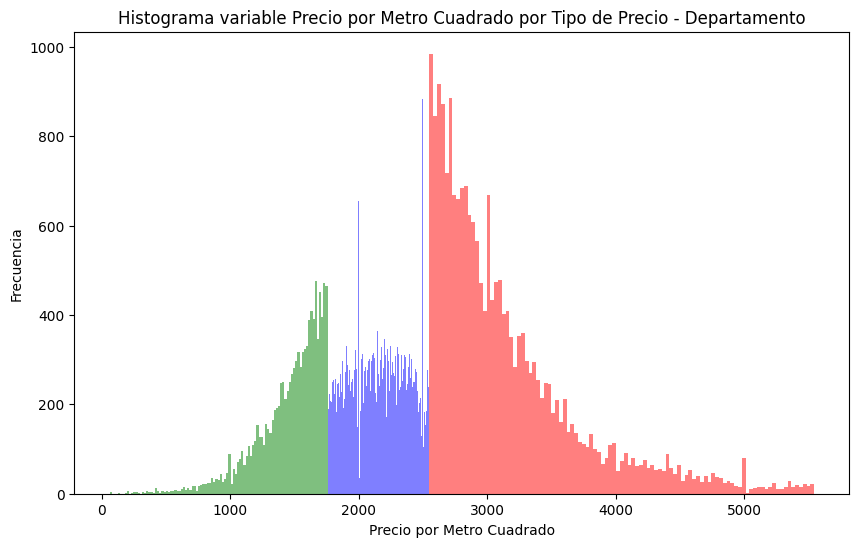

In [420]:
colors = {'Alto': 'red', 'Medio': 'blue', 'Bajo': 'green'}
plt.figure(figsize=(10, 6))
for tipo_precio, color in colors.items():
    data_por_tipo = pxm2_ascending_3_con_tipo_precio[(pxm2_ascending_3_con_tipo_precio['tipo_precio'] == tipo_precio) & (pxm2_ascending_3_con_tipo_precio['property_type'] == 'Departamento')]['price_per_square_meter']
    plt.hist(data_por_tipo, bins=101, color=color, alpha=0.5, label=tipo_precio)

plt.title("Histograma variable Precio por Metro Cuadrado por Tipo de Precio - Departamento")
plt.xlabel("Precio por Metro Cuadrado")
plt.ylabel("Frecuencia")
plt.show()

*falta mapa de caba*



TO DO

#REVISAR

## b. Entrenamiento y Prediccion

In [421]:
pxm2_ascending_3_con_tipo_precio.head()

,latitud,longitud,place_l3,property_type,property_bedrooms,property_rooms,property_surface_covered,property_surface_total,property_price,price_per_square_meter,tipo_precio
0,-34.574142,-58.408867,Palermo,Casa,2.0,3.0,72.0,230.0,90000.0,391.304348,Bajo
1,-34.608300,-58.371200,Monserrat,Casa,2.0,3.0,67.0,83.0,40000.0,481.927711,Bajo
2,-34.657288,-58.411771,Nueva Pompeya,Casa,2.0,3.0,80.0,132.0,74000.0,560.606061,Bajo
3,-34.646343,-58.363495,Boca,Casa,2.0,3.0,117.0,146.0,85000.0,582.191781,Bajo
4,-34.653845,-58.464647,Parque Avellaneda,Casa,2.0,3.0,91.0,91.0,56800.0,624.175824,Bajo


Se pide predecir el atributo tipo_precio excluyendo del entrenamiento la variable price, pxm2 y cualquier otra que pueda tener el precio de la venta.

In [422]:
df_por_tipo_de_propiedad = pxm2_ascending_3_con_tipo_precio.copy()

In [423]:
#Eliminar las columnas pxm2 y precio de la propiedad
df_por_tipo_de_propiedad.drop(['price_per_square_meter','property_price'], axis="columns", inplace=True)


In [424]:
df_por_tipo_de_propiedad.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65450 entries, 0 to 65449
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   latitud                   65450 non-null  float64
 1   longitud                  65450 non-null  float64
 2   place_l3                  65445 non-null  object 
 3   property_type             65450 non-null  object 
 4   property_bedrooms         65450 non-null  float64
 5   property_rooms            65450 non-null  float64
 6   property_surface_covered  65450 non-null  float64
 7   property_surface_total    65450 non-null  float64
 8   tipo_precio               65450 non-null  object 
dtypes: float64(6), object(3)
memory usage: 4.5+ MB


In [425]:
#importamos las librerias que vamos a utlizar
from sklearn.preprocessing import (
    OneHotEncoder,
    KBinsDiscretizer,
    LabelEncoder,
    StandardScaler,
    MinMaxScaler,
    Normalizer,
    PowerTransformer,
    OrdinalEncoder,
    RobustScaler,
)
oneHot = OneHotEncoder()

vamos a utilizar oneHot para las columnas place_l3 y property_type

In [426]:
df_dummies = pd.get_dummies(df_por_tipo_de_propiedad, columns=['property_type'],drop_first=True, dtype=int)

Para place_l3, vamos a calcular la cantidad de palabras y cuántas son en total, luego dropear el texto.

In [427]:
df_dummies['title_len'] = df_dummies['place_l3'].str.len()
df_dummies['title_words'] = df_dummies['place_l3'].str.split().str.len()
df_dummies.drop(['place_l3'], axis=1, inplace=True)

Escalo las vaiables numéricas.

In [428]:
columnas_num = [ 'property_rooms', 'property_bedrooms', 'property_surface_total', 'property_surface_covered','title_len','title_words']


In [429]:
standard_scaler = StandardScaler()
df_dummies[columnas_num] = standard_scaler.fit_transform(df_dummies[columnas_num])

In [430]:

df_dummies.head(10)

,latitud,longitud,property_bedrooms,property_rooms,property_surface_covered,property_surface_total,tipo_precio,property_type_Departamento,property_type_PH,title_len,title_words
0,-34.574142,-58.408867,0.442879,0.495165,0.458707,4.684825,Bajo,0,0,-0.793343,-0.637623
1,-34.608300,-58.371200,0.442879,0.495165,0.277233,0.397241,Bajo,0,0,-0.143673,-0.637623
2,-34.657288,-58.411771,0.442879,0.495165,0.749065,1.826436,Bajo,0,0,1.155667,1.230711
3,-34.646343,-58.363495,0.442879,0.495165,2.091970,2.234777,Bajo,0,0,-1.767848,-0.637623
4,-34.653845,-58.464647,0.442879,0.495165,1.148307,0.630579,Bajo,0,0,2.455007,1.230711
5,-34.654748,-58.427318,0.442879,0.495165,0.821654,2.351446,Bajo,0,0,1.155667,1.230711
6,-34.657288,-58.411771,0.442879,0.495165,0.386117,1.359760,Bajo,0,0,1.155667,1.230711
7,-34.647901,-58.507039,0.442879,0.495165,0.749065,2.934791,Bajo,0,0,-0.793343,-0.637623
8,-34.593367,-58.376541,0.442879,0.495165,0.313528,-0.040268,Bajo,0,0,-1.118178,-0.637623
9,-34.648968,-58.461769,0.442879,0.495165,2.200854,2.351446,Bajo,0,0,-1.118178,-0.637623


###Modelo 1 : Árbol de decisión

Instalamos dtreeviz

In [431]:
!pip install 'dtreeviz'

In [432]:
import dtreeviz

from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, accuracy_score,f1_score
from sklearn.metrics import confusion_matrix, classification_report

from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

vamos a separar el dataset.

In [433]:
df_dummies.dropna(inplace=True)

In [434]:
x_train = df_dummies.drop(['tipo_precio'], axis='columns', inplace=False)
y_train = df_dummies['tipo_precio'].copy()

In [435]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold, KFold,RandomizedSearchCV
from sklearn.metrics import make_scorer, f1_score

#Cantidad de combinaciones que voy a probar
n=10

#Conjunto de parámetros que quiero usar
params_grid = {'criterion':['gini','entropy'], 'min_samples_leaf':list(range(1,10)), 'min_samples_split': list(range(3,20)),
               'ccp_alpha':np.linspace(0,0.05,n), 'max_depth':list(range(1,6))}

#Cantidad de splits para el Cross Validation
folds=15

#Kfold estratificado
kfoldcv = StratifiedKFold(n_splits=folds)

base_tree = DecisionTreeClassifier()

#Metrica optimiza F1 Score
scorer_fn =  make_scorer(f1_score, average='micro')

#Random Search Cross Validation
randomcv = RandomizedSearchCV(estimator=base_tree, param_distributions = params_grid, scoring=scorer_fn, cv=kfoldcv, error_score='raise', n_iter=n)

#Buscamos los hiperparametros que optimizan F1 Score
randomcv.fit(x_train,y_train);

Para alcanzar su maximo valor en las metricas vamos a utilizar 15 folds.
 Elegimos F1 score por que es un balance entre las métricas de recall y presicion, preferimos no tener falsos negativos/positivos cuando predecimos el tipo de precio.

In [436]:
#Mejores hiperparametros del arbol
print(randomcv.best_params_)
#Mejor métrica
print(randomcv.best_score_)

{'min_samples_split': 4, 'min_samples_leaf': 8, 'max_depth': 5, 'criterion': 'gini', 'ccp_alpha': 0.005555555555555556}
0.5615402246160899


Conseguimos los mejores parámetros y la mejor métrica de las 10 iteraciones realizadas.

In [437]:
best_tree = randomcv.best_estimator_
feat_imps = best_tree.feature_importances_

for feat_imp,feat in sorted(zip(feat_imps,x_train.columns)):
  if feat_imp>0:
    print('{}: {}'.format(feat,feat_imp))

longitud: 0.08997790422604993
latitud: 0.4403755441202116
property_type_Departamento: 0.4696465516537385


Podemos ver los atributos que el árbol considera importantes para la clasificación.

Creamos el árbol que tiene los mejores hiperparámetros

In [438]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_text

arbol=DecisionTreeClassifier().set_params(**randomcv.best_params_)

#Entreno el arbol en todo el set
arbol.fit(x_train,y_train)

reglas = export_text(arbol, feature_names=list(x_train.columns))
print(reglas)

|--- latitud <= -34.60
|   |--- property_type_Departamento <= 0.50
|   |   |--- class: Alto
|   |--- property_type_Departamento >  0.50
|   |   |--- class: Medio
|--- latitud >  -34.60
|   |--- property_type_Departamento <= 0.50
|   |   |--- class: Alto
|   |--- property_type_Departamento >  0.50
|   |   |--- longitud <= -58.47
|   |   |   |--- class: Medio
|   |   |--- longitud >  -58.47
|   |   |   |--- class: Alto



In [439]:
feact = x_train.columns

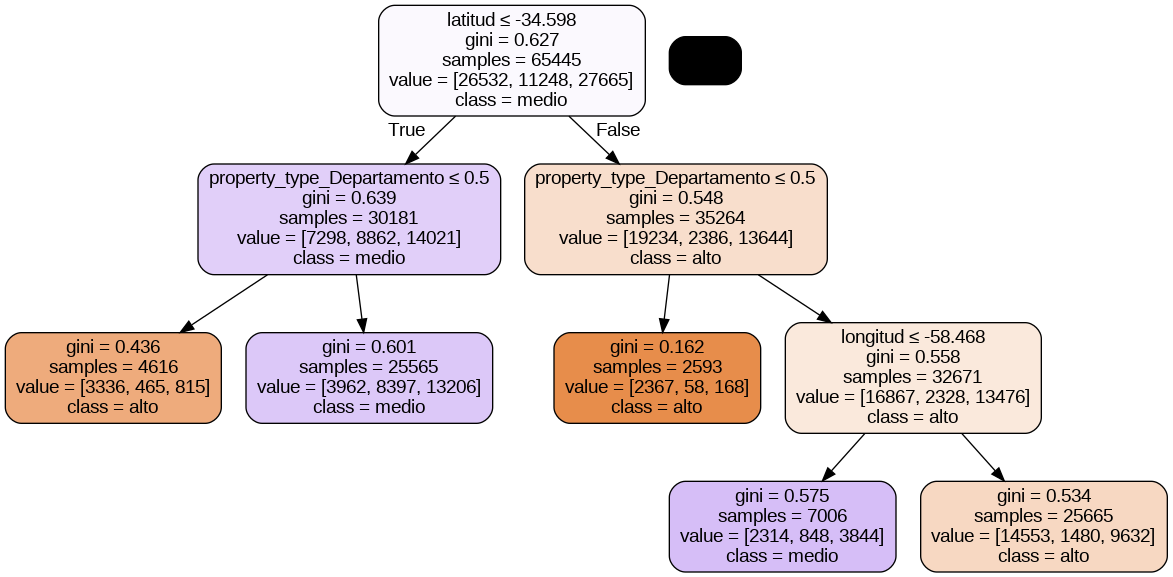

In [440]:
from six import StringIO
from IPython.display import Image
from sklearn.tree import export_graphviz
import pydotplus
import matplotlib.pyplot as plt

dot_data = StringIO()
export_graphviz(arbol, out_file=dot_data,
                filled=True, rounded=True,
                special_characters=True,
                feature_names=x_train.columns.to_list(),
                class_names=['alto','bajo','medio'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())

Podemos apreciar que clasifica un registro según los atributos que considera importantes expuestos anteriormente. Comienza considerando su latitud y, en el caso de la raíz, y según si cumple o no la condición se mueve hacia la derecha o izquierda.
El procedimiento sigue igual hasta llegar a la hoja en donde termina por clasificar el registro.

###Vamos a evaluar con conjunto de prueba


In [441]:
conjunto_prueba = pd.read_csv("Datasets/conjunto_prueba.csv")
df_prueba = conjunto_prueba.copy()
df_prueba.head()

,id,start_date,end_date,created_on,latitud,longitud,place_l2,place_l3,place_l4,place_l5,place_l6,operation,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,property_currency,property_title
0,dSC4wqerxQ5zoezS10hyig==,2021-08-24,2021-08-27,2021-08-24,-34.594832,-58.419821,Capital Federal,Palermo,NaN,NaN,NaN,Venta,Departamento,1.0,1.0,26.0,26.0,64765.0,USD,MONOAMBIENTE EMPRENDIMIENTO PALERMO SOHO
1,bObxHjQo1w/XUoA1CjdLtg==,2021-08-24,2021-08-24,2021-08-24,-34.585604,-58.423957,Capital Federal,Palermo,NaN,NaN,NaN,Venta,Departamento,1.0,NaN,32.0,30.0,110000.0,USD,Venta departamento en palermo monoambiente
2,xIjDPpdsenrj6u6ErpdNhg==,2021-08-24,2021-08-27,2021-08-24,-34.582800,-58.442800,Capital Federal,Palermo,NaN,NaN,NaN,Venta,Departamento,1.0,1.0,36.0,32.0,93621.0,USD,VENTA 1 AMBIENTE de 32 a 66 m² -VIVIENDA/ ESTU...
3,8b+kN4SeOF7UBH5dpfvg0Q==,2021-08-24,2021-10-18,2021-08-24,-34.577400,-58.433300,Capital Federal,Palermo,NaN,NaN,NaN,Venta,Departamento,2.0,1.0,42.0,38.0,79900.0,USD,VENTA DEPARTAMENTO 2 AMBIENTES EN PALERMO
4,O1XW6eVlW04mfAkXRKePkQ==,2021-08-24,2022-03-21,2021-08-24,-34.575328,-58.420624,Capital Federal,Palermo,NaN,NaN,NaN,Venta,Departamento,2.0,NaN,47.0,41.0,155000.0,USD,DEPARTAMENTO DUPLEX 2 AMBIENTES CON 2 BALCONES...


###vamos a preparar el dataset para poder utulizarlo

In [442]:
df_prueba.drop(['id', 'start_date', 'end_date', 'created_on', 'place_l5', 'place_l6', 'operation', 'place_l2', 'property_currency'], axis=1, inplace=True)
df_prueba.rename(columns={"place_l3":"zone"}, inplace=True)
df_prueba['zone'] = df_prueba.apply(lambda x: x['zone'] if str(x['place_l4']) == 'nan' else x['place_l4'], axis=1)
df_prueba.drop(['place_l4'], axis=1, inplace=True)

In [443]:
place_l3_copy = df_prueba["zone"]
place_l3_drop = place_l3_copy.drop_duplicates()
zones = place_l3_drop.values

media_zones = {}

for zone in zones:
      zone_act = df_prueba[df_prueba["zone"]==zone]
      lat_med = zone_act["latitud"].mean()
      lon_med = zone_act["longitud"].mean()
      media_zones[zone] = (lat_med,lon_med)
      zone_act = zone_act.fillna({"latitud":lat_med,"longitud":lon_med})
      df_prueba[df_prueba["zone"]==zone]=zone_act

In [444]:
import math

i = 0
while i < df_prueba.shape[0]:
  fila = df_prueba.iloc[i]
  lat = fila["latitud"]
  if math.isnan(lat):
    df_prueba.drop(df_prueba.index[i:i+1], inplace=True)
  else:
    i+=1

In [445]:
for i in range(1,df_prueba.shape[0]):
    fila = df_prueba.iloc[i]
    zona = fila["zone"]
    bool = zona!=zona

    if bool:
      lat=fila["latitud"]
      lon=fila["longitud"]
      dist_menor = abs( abs(media_zones["Palermo"][0]) - abs(lat) ) + abs( abs( abs(media_zones["Palermo"][1] ) - abs(lon) ))
      barrio = "Palermo"

      for a in media_zones:
          tupla_dist = media_zones.get(a)
          nueva_dist = abs( abs(tupla_dist[0]) - abs(lat) ) + abs( abs( abs(tupla_dist[1] ) - abs(lon) ))
          es_menor = nueva_dist<dist_menor

          if es_menor:
            dist_menor=nueva_dist
            barrio = a
      df_prueba.iat[i, 4] = barrio
    i+=1

df_prueba = df_prueba

In [446]:

i = 0
while i < df_prueba.shape[0]:
  fila = df_prueba.iloc[i]
  lat = fila["zone"]
  if str(lat) == 'nan':
    df_prueba.drop(df_prueba.index[i:i+1], inplace=True)
  else:
    i+=1
df_prueba["zone"].isna().value_counts()

zone
False    18793
Name: count, dtype: int64

In [447]:
prec_m2 = {}

for zona in zones:
  zona_act = df_prueba[df_prueba["zone"]==zona]
  prec_tot = 0
  sup_tot = 0

  for i in range(0,zona_act.shape[0]):
    fila = zona_act.iloc[i]
    prec = fila["property_price"]
    sup = fila["property_surface_total"]

    if not sup!=sup:
      prec_tot+=prec
      sup_tot+=sup

  if sup_tot!=0:
    prec_prom = prec_tot/sup_tot

    prec_m2[zona]= prec_prom

for i in range (0,df_prueba.shape[0]):
  fila = df_prueba.iloc[i]
  zona = fila["zone"]
  sup = fila["property_surface_total"]
  if sup!=sup:
      prec = fila["property_price"]
      sup_calc = prec/prec_m2.get(zona)
      df_prueba.iat[i, 9] = sup_calc

In [448]:
for i in range (0,df_prueba.shape[0]):
  fila = df_prueba.iloc[i]
  zona = fila["zone"]
  sup = fila["property_surface_total"]
  if sup!=sup:
      prec = fila["property_price"]
      sup_calc = prec/prec_m2.get(zona)
      df_prueba.iat[i, 9] = sup_calc

In [449]:
porc_sup_cub = {}

for zona in zones:
  zona_act = df_prueba[df_prueba["zone"]==zona]
  sup_tot = 0
  sup_cub = 0

  for i in range(0,zona_act.shape[0]):
    fila = zona_act.iloc[i]
    s_tot = fila["property_surface_total"]
    s_cub = fila["property_surface_covered"]

    if not s_cub!=s_cub:    #es decir si la columna property_surface_covered no es NaN
      sup_tot+=s_tot
      sup_cub+=s_cub

  if sup_tot!=0:
    porc_cub = (sup_cub * 100)/sup_tot
    porc_sup_cub[zona]= porc_cub

In [450]:
df_prueba.shape

(18793, 10)

In [451]:
conjunto_entrenamiento_final.shape

(65450, 10)

In [452]:
for i in range (0,df_prueba.shape[0]):
  fila = df_prueba.iloc[i]
  zona = fila["zone"]
  sup_cub = fila["property_surface_covered"]
  if sup_cub!=sup_cub:
      sup_tot = fila["property_surface_total"]
      nueva_sup_cub = sup_tot * porc_sup_cub.get(zona)
      conjunto_entrenamiento_final.iat[i, 9] = nueva_sup_cub

In [453]:
met_por_hab = {}

for zona in zones:
  zona_act = df_prueba[df_prueba["zone"]==zona]
  r_mediana = zona_act["property_rooms"].median()
  s_mediana = zona_act["property_surface_total"].median()
  met_por_hab[zona]=s_mediana/r_mediana

In [454]:
import math

i = 0
while i < df_prueba.shape[0]:
  fila = df_prueba.iloc[i]
  lat = fila["property_rooms"]
  if str(lat) == 'nan':
    df_prueba.drop(df_prueba.index[i:i+1], inplace=True)
  else:
    i+=1
df_prueba["property_rooms"].isna().value_counts()

property_rooms
False    18618
Name: count, dtype: int64

In [455]:
for i in range (0,df_prueba.shape[0]):
  fila = df_prueba.iloc[i]
  zona = fila["zone"]
  rooms = fila["property_rooms"]
  if rooms!=rooms:
      sup_cub = fila["property_surface_covered"]
      nuevo_rooms = sup_cub / met_por_hab.get(zona)
      df_prueba.iat[i, 7] = round(nuevo_rooms)

In [456]:
por_bedrooms = {}

rooms=df_prueba["property_rooms"].median()
bedrooms=df_prueba["property_bedrooms"].median()
porcentaje_mediana_gral = (bedrooms*100)/rooms


for zona in zones:
  zona_act = df_prueba[df_prueba["zone"]==zona]
  r_mediana = zona_act["property_rooms"].median()
  b_mediana = zona_act["property_bedrooms"].median()
  porcentaje = (b_mediana * 100)/r_mediana
  if porcentaje==100.0:
    porcentaje=porcentaje_mediana_gral
  por_bedrooms[zona] = porcentaje

In [457]:
for i in range (0,df_prueba.shape[0]):
  fila = df_prueba.iloc[i]
  zona = fila["zone"]
  bedrooms = fila["property_bedrooms"]
  if bedrooms!=bedrooms:
      rooms = fila["property_rooms"]
      calc_bedrooms = (rooms*por_bedrooms.get(zona)/100)
      df_prueba.iat[i, 8] = round(calc_bedrooms)

In [458]:
df_prueba.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18618 entries, 0 to 18849
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   latitud                   18618 non-null  float64
 1   longitud                  18618 non-null  float64
 2   zone                      18618 non-null  object 
 3   property_type             18618 non-null  object 
 4   property_rooms            18618 non-null  object 
 5   property_bedrooms         16578 non-null  float64
 6   property_surface_total    17986 non-null  float64
 7   property_surface_covered  18153 non-null  float64
 8   property_price            18618 non-null  float64
 9   property_title            18618 non-null  object 
dtypes: float64(6), object(4)
memory usage: 1.6+ MB


In [459]:
df_prueba.dropna(inplace=True)
df_prueba.drop(['zone'], axis=1, inplace=True)

Terminamos dropeando todas las filas que tienen datos nulos al finalizar, como también la columna de zonaa.

#### Preparar target

In [460]:
df_prueba.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15630 entries, 0 to 18849
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   latitud                   15630 non-null  float64
 1   longitud                  15630 non-null  float64
 2   property_type             15630 non-null  object 
 3   property_rooms            15630 non-null  object 
 4   property_bedrooms         15630 non-null  float64
 5   property_surface_total    15630 non-null  float64
 6   property_surface_covered  15630 non-null  float64
 7   property_price            15630 non-null  float64
 8   property_title            15630 non-null  object 
dtypes: float64(6), object(3)
memory usage: 1.2+ MB


In [461]:
df_prueba['price_per_square_meter'] = df_prueba['property_price'] / df_prueba['property_surface_total']

percentiles = [0, 0.25, 0.75, 1]
labels = ['bajo', 'medio', 'alto']
df_prueba["tipo_precio"] = pd.cut(df_prueba["price_per_square_meter"], bins=df_prueba["price_per_square_meter"].quantile(percentiles), labels=labels)

In [462]:
df_prueba.dropna(inplace=True)

In [463]:
df_prueba.drop(['price_per_square_meter', 'property_price'], axis=1, inplace=True)

###Ingeniería de características

In [464]:
df_prueba_dummies = pd.get_dummies(df_prueba, columns=['property_type'],drop_first=True, dtype=int)
df_prueba_dummies['title_len'] = df_prueba_dummies['property_title'].str.len()
df_prueba_dummies['title_words'] = df_prueba_dummies['property_title'].str.split().str.len()
df_prueba_dummies.drop(['property_title'], axis=1, inplace=True)

In [465]:
from sklearn.preprocessing import StandardScaler

standard_scaler = StandardScaler()
df_prueba_dummies[columnas_num] = standard_scaler.fit_transform(df_prueba_dummies[columnas_num])

In [466]:
df_dummies.head()

,latitud,longitud,property_bedrooms,property_rooms,property_surface_covered,property_surface_total,tipo_precio,property_type_Departamento,property_type_PH,title_len,title_words
0,-34.574142,-58.408867,0.442879,0.495165,0.458707,4.684825,Bajo,0,0,-0.793343,-0.637623
1,-34.608300,-58.371200,0.442879,0.495165,0.277233,0.397241,Bajo,0,0,-0.143673,-0.637623
2,-34.657288,-58.411771,0.442879,0.495165,0.749065,1.826436,Bajo,0,0,1.155667,1.230711
3,-34.646343,-58.363495,0.442879,0.495165,2.091970,2.234777,Bajo,0,0,-1.767848,-0.637623
4,-34.653845,-58.464647,0.442879,0.495165,1.148307,0.630579,Bajo,0,0,2.455007,1.230711


In [467]:
df_prueba_dummies.head()

,latitud,longitud,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,tipo_precio,property_type_Departamento,property_type_PH,title_len,title_words
0,-34.594832,-58.419821,-1.528993,-0.949396,-0.097498,-0.078213,medio,1,0,-0.437497,-1.188888
2,-34.582800,-58.442800,-1.528993,-0.949396,-0.085501,-0.070835,medio,1,0,0.175376,0.773285
3,-34.577400,-58.433300,-0.759697,-0.949396,-0.078302,-0.063456,medio,1,0,-0.376209,-0.534830
5,-34.573606,-58.432669,0.009598,0.019023,-0.053108,-0.036403,medio,1,0,-0.314922,-0.534830
6,-34.588245,-58.439884,-0.759697,-0.949396,-0.042311,-0.041322,alto,1,0,0.052801,1.100314


Reorganizo las columnas para que me queden en el mismo orden, las de prueba y las de entrenamiento

In [468]:
column_order = df_dummies.columns
df_prueba_dummies = df_prueba_dummies[column_order]

### Realizamos la Predicción

In [469]:
x_prueba = df_prueba_dummies.drop(['tipo_precio'], axis='columns', inplace=False)
y_prueba = df_prueba_dummies['tipo_precio'].copy()

F1-Score: 0.0


Text(50.722222222222214, 0.5, 'True')

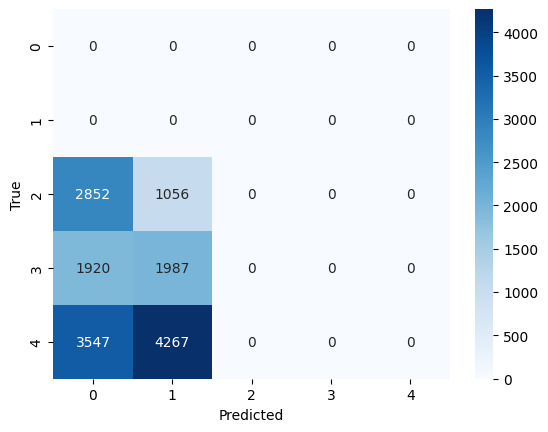

In [470]:
#Evalúo el Arbol con los mejores hiperparámetros
from sklearn.metrics import confusion_matrix, classification_report , f1_score

#predicción sobre el set de evaluacion
y_pred = arbol.predict(x_prueba)

#Arbol Reporte y Matriz de Confusion
print('F1-Score: {}'.format(f1_score(y_prueba, y_pred, average='micro')))

cm = confusion_matrix(y_prueba,y_pred)
sns.heatmap(cm, cmap='Blues',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')

In [471]:
print(classification_report(y_prueba,y_pred))

              precision    recall  f1-score   support

        Alto       0.00      0.00      0.00       0.0
       Medio       0.00      0.00      0.00       0.0
        alto       0.00      0.00      0.00    3908.0
        bajo       0.00      0.00      0.00    3907.0
       medio       0.00      0.00      0.00    7814.0

    accuracy                           0.00   15629.0
   macro avg       0.00      0.00      0.00   15629.0
weighted avg       0.00      0.00      0.00   15629.0



###ESCRIBIR OBSERVACIONES SOBRE LO DE ARRIBA

##Modelo 2: Random Forest

a. Construir un clasificador RF y optimizar sus hiperparámetros mediante k-fold Cross
Validation para obtener la mejor performance. ¿Cuántos folds utilizaron? ¿Qué
métrica consideran adecuada para buscar los parámetros?


b. Analizar la importancia de los atributos

 c. Mostrar la conformación final de uno de los árboles generados. Si es muy extenso mostrar una porción representativa y explicar las primeras reglas.

d. Evaluar la performance del modelo en el conjunto de evaluación, explicar todas las métricas y mostrar la matriz de confusión. Comparar con la performance de entrenamiento.

###Modelo 3: a elección

a. En este punto se debe entrenar (mediante cross-validation) un modelo elegido por el
grupo. Se debe evaluar su performance en entrenamiento y sobre el conjunto de
evaluación, explicar todas las métricas y mostrar la matriz de confusión.

¿Qué modelo elegirían para clasificar el tipo de precio de las propiedades?